In [7]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

## Load the Data

In [9]:
# Load the two CSV files
df_press = pd.read_csv('data/press_data.csv')
df_motion = pd.read_csv('data/motion_data.csv')

In [10]:
df_press.head()

,object,time_s,raw,voltage
0,beans,0.001,320,0.0161
1,beans,0.052,944,0.0475
2,beans,0.103,304,0.0153
3,beans,0.153,896,0.0451
4,beans,0.204,320,0.0161


In [11]:
df_motion.head()

,object,motion,force,raw,voltage
0,beans,slide,1,336,0.0169
1,beans,slide,1,464,0.0234
2,beans,slide,1,320,0.0161
3,beans,slide,1,256,0.0129
4,beans,slide,1,336,0.0169


In [25]:
# Get a list of objects (same for both dataframes)
objects = df_press['object'].unique()

## Visualisations

#### Line plots to visualise the press data for each object

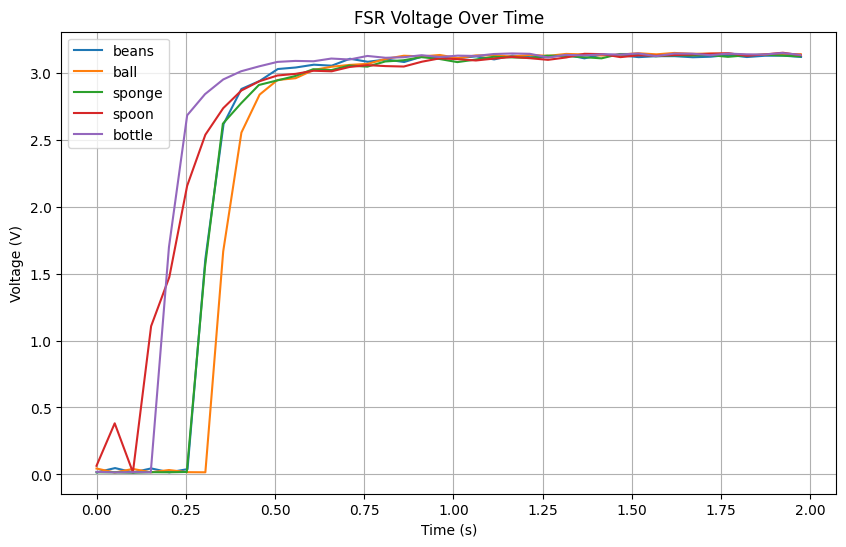

In [27]:
# Plot the curves for each object in the press data
plt.figure(figsize=(10, 6))
for object in objects:
    object_data = df_press[df_press['object'] == object]
    sns.lineplot(data=object_data, x='time_s', y='voltage', label=object)
plt.title('FSR Voltage Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)
plt.show()

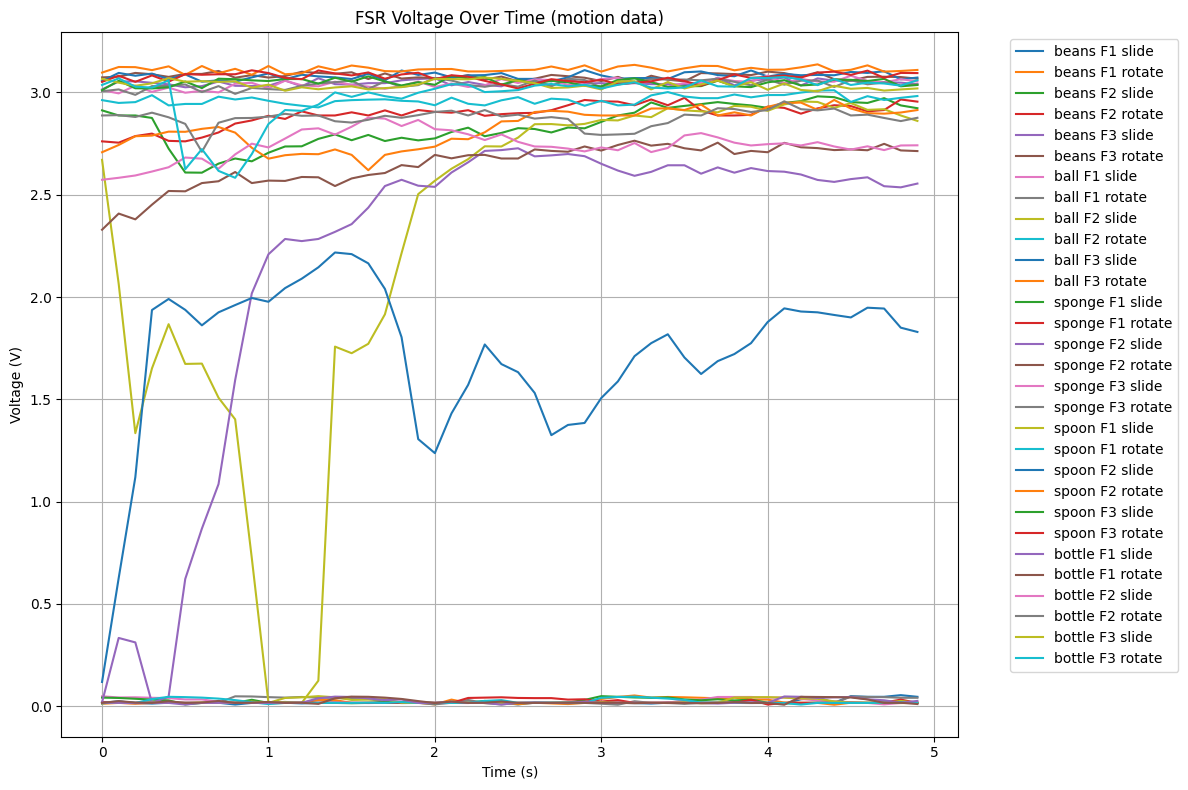

In [33]:
# Plot the curves for each object, motion and force level in the motion data
# Create a time column: samples are 0.1 s apart within each recording group
df_motion = df_motion.copy()
# ensure 'force' is numeric (if present) so grouping works as expected
if 'force' in df_motion.columns:
    try:
        df_motion['force'] = df_motion['force'].astype(int)
    except Exception:
        # leave as-is if conversion fails
        pass
# choose grouping columns depending on whether 'force' exists
group_cols = ['object', 'motion', 'force'] if 'force' in df_motion.columns else ['object', 'motion']
df_motion['time_s'] = df_motion.groupby(group_cols).cumcount() * 0.1

# Plot
plt.figure(figsize=(12, 8))
for obj in objects:
    obj_data = df_motion[df_motion['object'] == obj]
    if obj_data.empty:
        continue
    # iterate force levels in sorted order so legend is consistent
    if 'force' in obj_data.columns:
        forces = sorted(obj_data['force'].dropna().unique())
    else:
        forces = [None]

    for force in forces:
        for motion in ['slide', 'rotate']:
            if force is None:
                subset = obj_data[obj_data['motion'] == motion]
            else:
                subset = obj_data[(obj_data['force'] == force) & (obj_data['motion'] == motion)]
            if subset.empty:
                continue
            label = f"{obj} F{force} {motion}" if force is not None else f"{obj} {motion}"
            sns.lineplot(data=subset, x='time_s', y='voltage', label=label)

plt.title('FSR Voltage Over Time (motion data)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
# move legend outside the plot to avoid overlap when many lines exist
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Temperature for calibration:  
Temperature:      24.0°C  
Humidity:         59%  

Notes:  
Remove outliers   
Average  
Convert to N  
Fit curve  
Run inference on new V and get for each threshold  

Cables not touching, placed in centre of scales